In [2]:
# DeArrow Dataset: Imports and Paths
from pathlib import Path
import pandas as pd
import numpy as np

# Try multiple candidate locations relative to notebook and workspace
candidates = [
    Path('deArrow_data'),
    Path('../deArrow_data'),
    Path('../../Clickbait-project/deArrow_data'),
    Path.cwd() / 'deArrow_data'
]
for cand in candidates:
    if cand.exists():
        DATA_DIR = cand
        break
else:
    DATA_DIR = candidates[0]

print('Using DATA_DIR:', DATA_DIR)
print('Exists:', DATA_DIR.exists())
print('Files present:', [p.name for p in DATA_DIR.glob('*.csv')][:8])

Using DATA_DIR: ..\deArrow_data
Exists: True
Files present: ['casualVotes.csv', 'casualVoteTitles.csv', 'thumbnails.csv', 'thumbnailTimestamps.csv', 'thumbnailVotes.csv', 'titles.csv', 'titleVotes.csv', 'videoInfo.csv']


In [3]:
# Load core CSVs with basic checks
def load_csv(name):
    path = DATA_DIR / name
    df = pd.read_csv(path)
    print(f"✓ {name}: {len(df):,} rows, {df.columns.tolist()}")
    return df

titles = load_csv('titles.csv')
casual_titles = load_csv('casualVoteTitles.csv')
title_votes = load_csv('titleVotes.csv')
video_info = load_csv('videoInfo.csv')

print('Unique videoIDs (titles):', titles['videoID'].nunique())
print('Unique videoIDs (casual):', casual_titles['videoID'].nunique())

✓ titles.csv: 493,305 rows, ['videoID', 'title', 'original', 'timeSubmitted', 'UUID', 'casualMode']
✓ casualVoteTitles.csv: 12,571 rows, ['videoID', 'id', 'title']
✓ titleVotes.csv: 493,235 rows, ['UUID', 'votes', 'locked', 'shadowHidden', 'verification', 'downvotes', 'removed']
✓ videoInfo.csv: 9,846,585 rows, ['videoID', 'channelID', 'title', 'published']
Unique videoIDs (titles): 356427
Unique videoIDs (casual): 12426


In [4]:
# Create clickbait → neutral pairs
titles_with_votes = titles.merge(title_votes[['UUID','votes']], on='UUID', how='left')

pairs = []
for vid in casual_titles['videoID'].unique():
    ct = casual_titles[casual_titles['videoID'] == vid]
    tt = titles_with_votes[titles_with_votes['videoID'] == vid]
    if len(ct) and len(tt):
        neutral_title = ct.iloc[0]['title']
        tt_sorted = tt.sort_values('votes', ascending=False, na_position='last')
        clickbait_title = tt_sorted.iloc[0]['title']
        pairs.append({'videoID': vid, 'clickbait_title': clickbait_title, 'neutral_title': neutral_title, 'clickbait_votes': tt_sorted.iloc[0].get('votes', 0)})

pairs_df = pd.DataFrame(pairs)
# Filter to videoIDs present in video_info
vi_ids = set(video_info['videoID'].dropna().unique())
pairs_df = pairs_df[pairs_df['videoID'].isin(vi_ids)]
print('Pairs created:', len(pairs_df))
pairs_df.head(5)

Pairs created: 5915


,videoID,clickbait_title,neutral_title,clickbait_votes
0,VJFaO2-zsCU,Several types of malware and other computer-re...,every type of computer virus explained in 8 mi...,1.0
2,3qt9H2rkwxo,Criticism of DOGE and the trimming down of US ...,a video essay about efficiency,0.0
3,GZfFPI8LJrc,AMD RDNA 4 and RX 9000 series reveal,all you need for gaming – amd rdna™ 4 and rx 9...,0.0
4,855YrspL4o8,I'm gaming: War Thunder,flying airplanes is incredibly easy.,0.0
6,RKZHim8d-30,We Try 10 Difficult Exercises,level 1 to 100 impossible exercises,1.0


In [5]:
# Feature engineering helpers
import re
def extract_text_features(text):
    if pd.isna(text):
        return {'length':0,'word_count':0,'char_per_word':0,'uppercase_ratio':0,'digit_count':0,'exclamation_count':0,'question_count':0,'ellipsis_count':0,'caps_words':0,'has_emoji':False,'has_number':False,'has_caps_sequence':False}
    s = str(text).strip()
    return {
        'length': len(s),
        'word_count': len(s.split()),
        'char_per_word': len(s)/max(1,len(s.split())),
        'uppercase_ratio': sum(1 for c in s if c.isupper())/max(1,len(s)),
        'digit_count': sum(1 for c in s if c.isdigit()),
        'exclamation_count': s.count('!'),
        'question_count': s.count('?'),
        'ellipsis_count': s.count('...'),
        'caps_words': sum(1 for w in s.split() if w.isupper() and len(w)>1),
        'has_emoji': bool(re.search(r'[\U0001F300-\U0001F9FF]', s)),
        'has_number': bool(re.search(r'\d', s)),
        'has_caps_sequence': bool(re.search(r'[A-Z]{3,}', s)),
    }

def detect_language(text):
    if pd.isna(text): return 'unknown'
    s = str(text)
    if re.search(r'[а-яА-ЯёЁ]', s): return 'ru'
    if re.search(r'[àáâãäåèéêëìíîïòóôõöùúûüñç]', s):
        if re.search(r'¿|¡', s): return 'es'
        elif re.search(r'(ione|ità|ezza)$', s): return 'it'
        else: return 'other_romance'
    return 'en'

def add_features(df, col, prefix=''):
    feats = df[col].apply(extract_text_features).apply(pd.Series)
    feats = feats.add_prefix(prefix) if prefix else feats
    return pd.concat([df, feats], axis=1)

In [6]:
# Apply features and language detection
pairs_features = add_features(pairs_df.copy(), 'clickbait_title', prefix='clickbait_')
pairs_features = add_features(pairs_features, 'neutral_title', prefix='neutral_')
pairs_features['language'] = pairs_features['clickbait_title'].apply(detect_language)
print('Feature columns:', [c for c in pairs_features.columns if c.startswith('clickbait_') or c.startswith('neutral_')][:6], '...')
pairs_features.head(3)

Feature columns: ['clickbait_title', 'neutral_title', 'clickbait_votes', 'clickbait_length', 'clickbait_word_count', 'clickbait_char_per_word'] ...


,videoID,clickbait_title,neutral_title,clickbait_votes,clickbait_length,clickbait_word_count,clickbait_char_per_word,clickbait_uppercase_ratio,clickbait_digit_count,clickbait_exclamation_count,...,neutral_uppercase_ratio,neutral_digit_count,neutral_exclamation_count,neutral_question_count,neutral_ellipsis_count,neutral_caps_words,neutral_has_emoji,neutral_has_number,neutral_has_caps_sequence,language
0,VJFaO2-zsCU,Several types of malware and other computer-re...,every type of computer virus explained in 8 mi...,1.0,82,12,6.833333,0.012195,1,0,...,0.0,1,0,0,0,0,False,True,False,en
2,3qt9H2rkwxo,Criticism of DOGE and the trimming down of US ...,a video essay about efficiency,0.0,94,16,5.875000,0.074468,0,0,...,0.0,0,0,0,0,0,False,False,False,en
3,GZfFPI8LJrc,AMD RDNA 4 and RX 9000 series reveal,all you need for gaming – amd rdna™ 4 and rx 9...,0.0,36,8,4.500000,0.250000,5,0,...,0.0,5,0,0,0,0,False,True,False,en


Total pairs: 5915
Language distribution:
 language
en               5756
other_romance     100
ru                 59
Name: count, dtype: int64


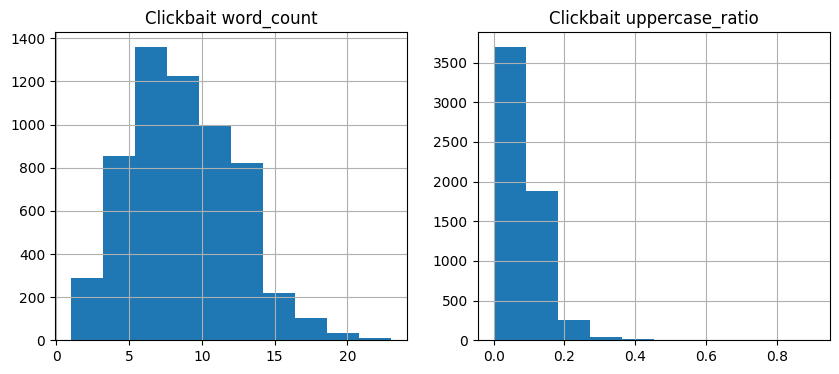

In [7]:
# Summary stats and visuals
print('Total pairs:', len(pairs_features))
print('Language distribution:\n', pairs_features['language'].value_counts())

import matplotlib.pyplot as plt
fig, axes = plt.subplots(1,2, figsize=(10,4))
pairs_features['clickbait_word_count'].hist(ax=axes[0])
axes[0].set_title('Clickbait word_count')
pairs_features['clickbait_uppercase_ratio'].hist(ax=axes[1])
axes[1].set_title('Clickbait uppercase_ratio')
plt.show()

In [9]:
# Save processed pairs to CSV
from pathlib import Path
out_path = Path('processed_clickbait_pairs.csv')  # save next to the notebook
pairs_features.to_csv(out_path, index=False)
print('Saved:', out_path.resolve(), 'rows:', len(pairs_features))

Saved: C:\Users\Sahar\Desktop\Clickbait_git\Clickbait-project\EDA\processed_clickbait_pairs.csv rows: 5915
